In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage import io

from vis import *

254.97 325.05


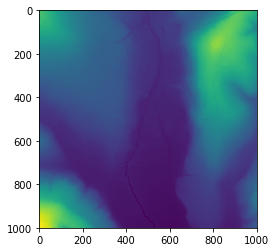

In [2]:
#nlin = 2000
#ncol = 3000
#dem = np.arange(nlin*ncol).reshape(nlin,ncol)
#dem = (np.sin(dem * 0.01) + np.random.rand(nlin,ncol))
#dem = np.minimum(dem, 50)
#print(dem.min(), dem.max(), dem.mean())
#plt.imshow(dem)
#print(np.histogram(dem))

dem = io.imread("/home/klemen/_repo_RVT/RVT_py/test_data/TM1_564_146.tif")

print(dem.min(),dem.max())
plt.imshow(dem)
plt.show()

In [3]:
tic = time.time()
orig = sky_view_factor(dem, 1, compute_svf=True, compute_opns=True, compute_asvf=True,
                    svf_n_dir=32, svf_r_max=10, svf_noise=0, asvf_dir=315, asvf_level=1)
toc = time.time()
print(toc-tic)

5.009167909622192


In [4]:
def horizon_shift_vector(num_directions=16, 
                         radius_pixels=10, 
                         min_radius=1,
                         ):
    
    """
    Calculates Sky-View determination movements.

    Parameters
    ----------
    num_directions : number of directions as input
    radius_pixels : radius to consider in pixels (not in meters)
    min_radius : radius to start searching for horizon in pixels (not in meters)


    Returns
    -------
    shift : dict with keys corresponding to the directions of search azimuths rounded to 1 decimal number
            - for each key, a subdict contains a key "shift":
                values for this key is a list of tuples prepared for np.roll - shift along lines and columns
            - the second key is "distance":
                values for this key is a list of search distances used for the computation of the elevation angle 
    """
    
    # Initialize the output dict
    shift = {}

    # Generate angles and corresponding normal shifts in X (columns)
    # and Y (lines) direction
    angles = (2 * np.pi / num_directions) * np.arange(num_directions) 
    x = np.cos(angles)
    y = np.sin(angles)
    angles = np.round(np.degrees(angles), decimals=1)
    
    # Generate a range of radius values in pixels.
    # Make it finer for the selcted scaling.
    # By adding the last constant we make sure that we do not start with
    # point (0,0).
    scale = 3.
    radii = np.arange(radius_pixels*scale-scale+1) / scale + min_radius

    # For each direction compute all possible horizont point position
    # and round them to integers
    for i in range(num_directions):
        x_int = np.round(x[i] * radii, decimals=0)
        y_int = np.round(y[i] * radii, decimals=0)
        # consider only the minimal number of points
        # use the trick with set and complex nuber as the input
        coord_complex = set(x_int + 1j * y_int)
        # to sort proportional with increasing radius, 
        # set has to be converted to numpy array
        shift_pairs = np.array([(k.real, k.imag) for k in coord_complex]).astype(int)
        distance = np.sqrt(np.sum(shift_pairs**2, axis=1))
        sort_index = np.argsort(distance)
        # write for each direction shifts and corresponding distances
        shift[angles[i]] = {
            "shift": [(k[0],k[1]) for k in shift_pairs[sort_index]],
            "distance": distance[sort_index],
            }

    return shift

In [5]:
a=horizon_shift_vector(16, 10, 1)
for i in a.keys():
    print(f"angle {i}")
    for j in a[i]:
        print(f"{j}: {a[i][j]}")

angle 0.0
shift: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0)]
distance: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
angle 22.5
shift: [(1, 0), (1, 1), (2, 1), (3, 1), (4, 2), (5, 2), (6, 2), (6, 3), (7, 3), (8, 3), (9, 4)]
distance: [1.         1.41421356 2.23606798 3.16227766 4.47213595 5.38516481
 6.32455532 6.70820393 7.61577311 8.54400375 9.8488578 ]
angle 45.0
shift: [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7)]
distance: [1.41421356 2.82842712 4.24264069 5.65685425 7.07106781 8.48528137
 9.89949494]
angle 67.5
shift: [(0, 1), (1, 1), (1, 2), (1, 3), (2, 4), (2, 5), (2, 6), (3, 6), (3, 7), (3, 8), (4, 9)]
distance: [1.         1.41421356 2.23606798 3.16227766 4.47213595 5.38516481
 6.32455532 6.70820393 7.61577311 8.54400375 9.8488578 ]
angle 90.0
shift: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10)]
distance: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
angle 112.5
shift: [(0, 1), (-1, 1), (-1, 2), (-1,

In [6]:
sky_view_det_move(16, 10, 1000)

array([[[-1.0000000e+03, -1.0000000e+03, -9.9900000e+02,  1.0000000e+00,
          1.0000000e+00,  1.0000000e+00,  1.0010000e+03,  1.0010000e+03,
          1.0000000e+03,  9.9900000e+02,  9.9900000e+02,  9.9900000e+02,
         -1.0000000e+00, -1.0010000e+03, -1.0010000e+03, -1.0010000e+03],
        [-2.0000000e+03, -1.9990000e+03, -1.9980000e+03, -9.9800000e+02,
          2.0000000e+00,  1.0020000e+03,  2.0020000e+03,  2.0010000e+03,
          2.0000000e+03,  1.9990000e+03,  1.9980000e+03,  9.9800000e+02,
         -2.0000000e+00, -1.0020000e+03, -2.0020000e+03, -2.0010000e+03],
        [-3.0000000e+03, -2.9990000e+03, -2.9970000e+03, -9.9700000e+02,
          3.0000000e+00,  1.0030000e+03,  3.0030000e+03,  3.0010000e+03,
          3.0000000e+03,  2.9990000e+03,  2.9970000e+03,  9.9700000e+02,
         -3.0000000e+00, -1.0030000e+03, -3.0030000e+03, -3.0010000e+03],
        [-4.0000000e+03, -3.9980000e+03, -3.9960000e+03, -1.9960000e+03,
          4.0000000e+00,  2.0040000e+03,  4.0040

In [7]:
def sky_view_factor_com_new(height_arr, 
                            radius_max=10, 
                            radius_min=1, 
                            num_directions=16,
                            compute_svf=True, 
                            compute_opns=False,
                            compute_asvf=False, 
                            a_main_direction=315., 
                            a_poly_level=4, 
                            a_min_weight=0.4,
                            ):
    """
    Calculates horizon based visualizations: Sky-view factor, Anisotopic SVF and Openess.

    Parameters
    ----------
    height_arr : elevation (DEM) as 2D numpy array
    radius_max : maximal search radius in pixels/cells (not in meters)
    radius_min : minimal search radius in pixels/cells (not in meters), for noise reduction
    num_directions : number of directions as input
    compute_svf : if true it computes and outputs svf
    compute_asvf : if true it computes and outputs asvf
    compute_opns : if true it computes and outputs opns
    a_main_direction : main direction of anisotropy
    a_poly_level : level of polynomial that determines the anisotropy
    a_min_wight : weight to consider anisotropy:
                 0 - low anisotropy, 
                 1 - high  anisotropy (no illumination from the direction opposite the main direction)

    Returns
    -------
    {"svf": svf_out, "asvf": asvf_out, "opns": opns_out} : dictionary
        svf_out, skyview factor : 2D array of skyview factor.
        asvf_out, anisotropic skyview factor : 2D array of anisotropic skyview factor.
        opns_out, openness : 2D array openness (elevation angle of horizon)
    """

    # pad the array for the radius_max on all 4 sides
    height = np.pad(height_arr, radius_max, mode='symmetric')

    # compute the vector of movement and corresponding distances
    move = horizon_shift_vector(num_directions=num_directions, radius_pixels=radius_max, min_radius=radius_min)

    # init the output for usual SVF
    if compute_svf:
        svf_out = np.zeros(height.shape, dtype=np.float32)
    else:
        svf_out = None
    # init the output for azimuth dependent SVF
    if compute_asvf:
        asvf_out = np.zeros(height.shape, dtype=np.float32)
        w_m = a_min_weight
        w_a = np.deg2rad(a_main_direction)
        weight = np.arange(num_directions) * (2 * np.pi / num_directions)
        weight = (1 - w_m) * (np.cos((weight - w_a) / 2)) ** a_poly_level + w_m
    else:
        asvf_out = None
    # init the output for Openess
    if compute_opns:
        opns_out = np.zeros(height.shape, dtype=np.float32)
    else:
        opns_out = None 

    # search for horizon in each direction...
    for i_dir, direction in enumerate(move):
        # reset maximum at each iteration (direction)
        max_slope = np.zeros(height.shape, dtype=np.float32) - 1000

        # ... and to the search radius
        for i_rad, radius in enumerate(move[direction]["distance"]):
            # get shift index from move dictionary
            shift_indx = move[direction]["shift"][i_rad]
            # estimate the slope
            _ = (np.roll(height, shift_indx, axis=(0,1)) - height) / radius
            # compare to the previus max slope and keep the larges
            max_slope = np.maximum(max_slope, _)
        
        # convert to angle in radians and compute directional output
        _ = np.arctan(max_slope)
        if compute_svf:
            svf_out = svf_out + (1 - np.sin(np.maximum(_,0)))
        if compute_asvf:
            asvf_out = asvf_out + (1 - np.sin(np.maximum(_,0))) * weight[i_dir]
        if compute_opns:
            opns_out = opns_out + _

    # cut to original extent and 
    # average the directional output over all directions
    if compute_svf:
        svf_out = svf_out[radius_max:-radius_max, radius_max:-radius_max] / num_directions
    if compute_asvf:
        asvf_out = asvf_out[radius_max:-radius_max, radius_max:-radius_max]  / np.sum(weight)
    if compute_opns:
        opns_out = np.rad2deg(0.5 * np.pi - (opns_out[radius_max:-radius_max, radius_max:-radius_max] / num_directions))

    # return results within dict
    dict_svf_asvf_opns = {"svf": svf_out, "asvf": asvf_out, "opns": opns_out}
    dict_svf_asvf_opns = {k: v for k, v in dict_svf_asvf_opns.items() if v is not None}  # filter out none

    return dict_svf_asvf_opns

In [8]:
tic = time.time()
new = sky_view_factor_com_new(dem, 
                            radius_max=10, 
                            radius_min=1, 
                            num_directions=32,
                            compute_svf=True,
                            compute_asvf=True,
                            compute_opns=True)

toc = time.time()
print(toc-tic)

3.250133752822876


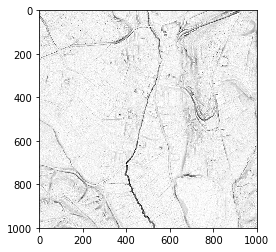

In [9]:
plt.imshow(new["opns"], cmap="gray", vmin=60., vmax=90)


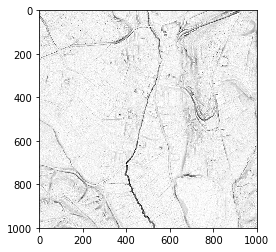

In [10]:
plt.imshow(new["opns"], cmap="gray", vmin=60., vmax=90)

In [11]:
print(np.mean(np.abs(new["opns"]-orig["opns"])))

0.37981772
